In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import scanpy as sc
from collections import Counter
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches
import scipy.stats
from sklearn.neighbors import BallTree
from scipy.sparse import csgraph
from sklearn.decomposition import PCA
import scipy
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from sklearn import metrics
import tabulate
import gget
from scipy.stats import gmean


# locals
import utils as ut


In [2]:
def printGSR(ef, top=None, columns=['path_name', 'overlapping_genes']):
    """A function to print pathway results """
    n = top
    if top is None:
        n = len(ef)

    ef['overlapping_genes'] = ef['overlapping_genes'].apply(lambda x: ", ".join(x))
    printDf = ef[columns].head(n)
    print(tabulate.tabulate(printDf, 
                            headers=columns, 
                            showindex=False,
                            tablefmt='orgtbl'))

In [3]:
dirPath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/scanpy/"

adata = {}

for f in os.listdir(dirPath):
    
    if f.endswith('.h5ad'):
        key = f.split(".")[0]
        fullPath = f"{dirPath}{f}"
        data = sc.read(fullPath)
        adata[key] = data
    
print("done")

done


In [4]:
cardOutDir = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDOuputs/"

dfList = []

for f in os.listdir(cardOutDir):
    if 'macrophage' in f:
        fullPath = f"{cardOutDir}{f}"
        key = f.split("_")[0]
        df = pd.read_csv(fullPath)
        df = df.rename(columns={'Unnamed: 0' : 'spotId'})
        df['key'] = key
        dfList.append(df)

df = pd.concat(dfList, ignore_index=True)
print(f"{df.shape=}")
print(df['key'].value_counts())
print()
cTypes = df.columns.to_list()
cTypes.remove("key")
cTypes.remove("spotId")
print(cTypes)
print()
df.head()

df.shape=(14836, 13)
HFD8     6782
ND       4068
HFD14    3986
Name: key, dtype: int64

['Dendritic cells', 'Mac4', 'Stromal cells', 'NK cells', 'Mac2', 'Monocytes', 'T cells', 'Mac5', 'Mac3', 'Mac1', 'B cells']



,spotId,Dendritic cells,Mac4,Stromal cells,NK cells,Mac2,Monocytes,T cells,Mac5,Mac3,Mac1,B cells,key
0,AAACAAGTATCTCCCA.1,0.087213,0.113186,0.270488,0.096431,0.057255,0.083130,0.047384,0.163491,0.049659,0.006606,0.025157,HFD8
1,AAACACCAATAACTGC.1,0.159247,0.129071,0.105884,0.002606,0.084753,0.088446,0.016601,0.302068,0.046115,0.038813,0.026395,HFD8
2,AAACAGCTTTCAGAAG.1,0.042437,0.128286,0.329050,0.064440,0.050805,0.049080,0.052493,0.100578,0.065773,0.025274,0.091783,HFD8
3,AAACAGGGTCTATATT.1,0.038153,0.094966,0.294255,0.055503,0.061959,0.060107,0.048176,0.127678,0.099188,0.040547,0.079468,HFD8
4,AAACAGTGTTCCTGGG.1,0.000020,0.256841,0.323585,0.003329,0.015668,0.010229,0.002518,0.222850,0.000587,0.000737,0.163636,HFD8


In [5]:
sptDir =  "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDInputs/"

spt = {}

for f in os.listdir(sptDir):
    if "spt" in f and "macrophage" in f:
        print(f)
        fullPath = f"{sptDir}{f}"
        key = f.split("_")[0]
        sdf = pd.read_csv(fullPath)
        sdf = sdf.rename(columns={'Unnamed: 0' : 'gene'})
        sdf = sdf.set_index('gene')
        sdf = sdf.T
        sdf.index = sdf.index.str.replace("-", ".")
        spt[key] = sdf
    
print('done')

HFD8_macrophage_spt.csv
HFD14_macrophage_spt.csv
ND_macrophage_spt.csv
done


In [6]:
fPath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/LR/LewisLabUSCS/Mouse/Mouse-2020-Baccin-LR-pairs.xlsx"

lr = pd.read_excel(fPath)
print(lr.shape)

lr['ligand'] = lr['Ligand.Mouse'].str.upper()
lr['receptor'] = lr['Receptor.Mouse'].str.upper()
lr.head()

(2000, 8)


,Pair.Name,Ligand.Mouse,Receptor.Mouse,Source,ManualAnnotation,Ligand.CC,Ligand.GO,Reference (PMID / KEGG),ligand,receptor
0,A2m-Lrp1,A2m,Lrp1,Ramilowski,Correct,Secreted,Other,"1702392,10652313, 12194978",A2M,LRP1
1,Adgre5-Cd55,Adgre5,Cd55,Baccin,Correct,Membrane,Other,23447688,ADGRE5,CD55
2,Adipoq-Adipor1,Adipoq,Adipor1,Ramilowski,Correct,Secreted,Other,12802337,ADIPOQ,ADIPOR1
3,Adipoq-Adipor2,Adipoq,Adipor2,Ramilowski,Correct,Secreted,Other,"12802337, 12802330",ADIPOQ,ADIPOR2
4,Adm-Calcrl&Ramp2,Adm,Calcrl&Ramp2,Baccin,Correct,Secreted,Other,10342881,ADM,CALCRL&RAMP2


In [7]:
coordDir = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDInputs/"

dfList = []

for f in os.listdir(coordDir):
    if "coord" in f:
        fullPath = f"{coordDir}{f}"
        key = f.split("_")[0]
        cdf = pd.read_csv(fullPath)
        cdf = cdf.rename(columns={'Unnamed: 0' : 'spotId'})
        cdf['key'] = key
        dfList.append(cdf)

cdf = pd.concat(dfList, ignore_index=True)
print(f"{cdf.shape=}")
print(cdf['key'].value_counts())
print()
cdf.head()

cdf.shape=(14848, 4)
HFD8     6788
ND       4072
HFD14    3988
Name: key, dtype: int64



,spotId,x,y,key
0,AAACATTTCCCGGATT.1,1139.783401,1365.804581,HFD14
1,AAACCGGGTAGGTACC.1,468.056902,1045.415505,HFD14
2,AAACCGTTCGTCCAGG.1,604.524374,1214.452428,HFD14
3,AAACCTAAGCAGCCGG.1,1003.708924,1433.743571,HFD14
4,AAACCTCATGAAGTTG.1,380.369919,960.970730,HFD14


In [8]:
"""Merge CARD predictions with spatial coordinates"""
df = pd.merge(cdf, df,
              how='left', 
              left_on=['spotId', 'key'],
              right_on=['spotId', 'key'])

df = df.fillna(0)
df = df.drop_duplicates() # very important!
print(df['key'].value_counts())
df.head()

HFD8     3394
ND       2036
HFD14    1994
Name: key, dtype: int64


,spotId,x,y,key,Dendritic cells,Mac4,Stromal cells,NK cells,Mac2,Monocytes,T cells,Mac5,Mac3,Mac1,B cells
0,AAACATTTCCCGGATT.1,1139.783401,1365.804581,HFD14,3.468007e-02,0.007548,0.409201,0.170860,0.004757,0.041542,0.055275,0.219997,0.010912,0.004188,0.041040
2,AAACCGGGTAGGTACC.1,468.056902,1045.415505,HFD14,1.280364e-03,0.088368,0.187514,0.019633,0.028867,0.129969,0.040070,0.450618,0.008903,0.013757,0.031021
4,AAACCGTTCGTCCAGG.1,604.524374,1214.452428,HFD14,3.752028e-04,0.004256,0.283055,0.187004,0.021560,0.108340,0.044845,0.310869,0.003200,0.004016,0.032480
6,AAACCTAAGCAGCCGG.1,1003.708924,1433.743571,HFD14,1.198581e-07,0.009084,0.239973,0.043516,0.004948,0.057287,0.052469,0.558332,0.000064,0.023214,0.011113
8,AAACCTCATGAAGTTG.1,380.369919,960.970730,HFD14,1.377525e-02,0.029749,0.216199,0.122802,0.053188,0.158933,0.041466,0.234411,0.043126,0.037127,0.049224


In [9]:
keys = ['ND', 'HFD8', 'HFD14']

lrData = {}

for key in keys:
    sdf = spt[key]
    newCols = {}
    
    for idx, row in lr.iterrows():
        l = row['ligand']
        r = row['receptor']
        
        if l in sdf.columns and r in sdf.columns:
            gMean = scipy.stats.gmean(sdf[[l, r]], axis=1)
            lrName = row['Pair.Name']
            newCols[lrName] = gMean
    
    lrdf = pd.DataFrame(newCols)
    lrdf.index = sdf.index
    
    # remove zero-sum columns 
    lrdf = lrdf.loc[:, (lrdf.sum(axis=0) != 0)]
    print(sdf.shape, lrdf.shape)
    
    lrData[key] = lrdf


print('done')

(2036, 31053) (2036, 124)
(3394, 31053) (3394, 253)
(1994, 31053) (1994, 270)
done


In [10]:
irePath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/annotations/IRE1_substrates.txt"
ire = [x.upper().strip() for x in open(irePath)]
print(f"{len(ire)=}")
ire[:10]

len(ire)=809


['NARF',
 'FER',
 'XPO6',
 'ACVR1B',
 'B9D1',
 'PCNT',
 'LSR',
 'PFDN5',
 'ITGA3',
 'NUP214']

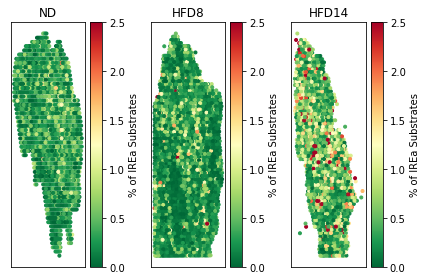

In [11]:
keys = ['ND', 'HFD8', 'HFD14']

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 15, 4
plt.rcParams['figure.facecolor'] = "w"


fig, axs = plt.subplots(1, 3)
axs = axs.ravel()
cmap = 'RdYlGn_r'

for i, key in enumerate(keys):
    kdf = df[df['key'] == key]
    sdf = spt[key]
    
    X = sdf[ire].astype(bool)
    rowSums = (X.sum(axis=1) / len(X)) * 100
    
    p = axs[i].scatter(kdf['x'], 
                       kdf['y'], 
                       c=rowSums, 
                       marker=".", 
                       vmin=0, 
                       vmax=2.5, 
                       cmap=cmap)

    axs[i].set_xlabel("")
    axs[i].set_ylabel("")
    
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    
    axs[i].invert_yaxis()
    axs[i].set_title(key)
    plt.colorbar(p, ax=axs[i], label="% of IREa Substrates")    
    
plt.tight_layout() 


(809,) (2036, 31053)
(809,) (3394, 31053)
(809,) (1994, 31053)


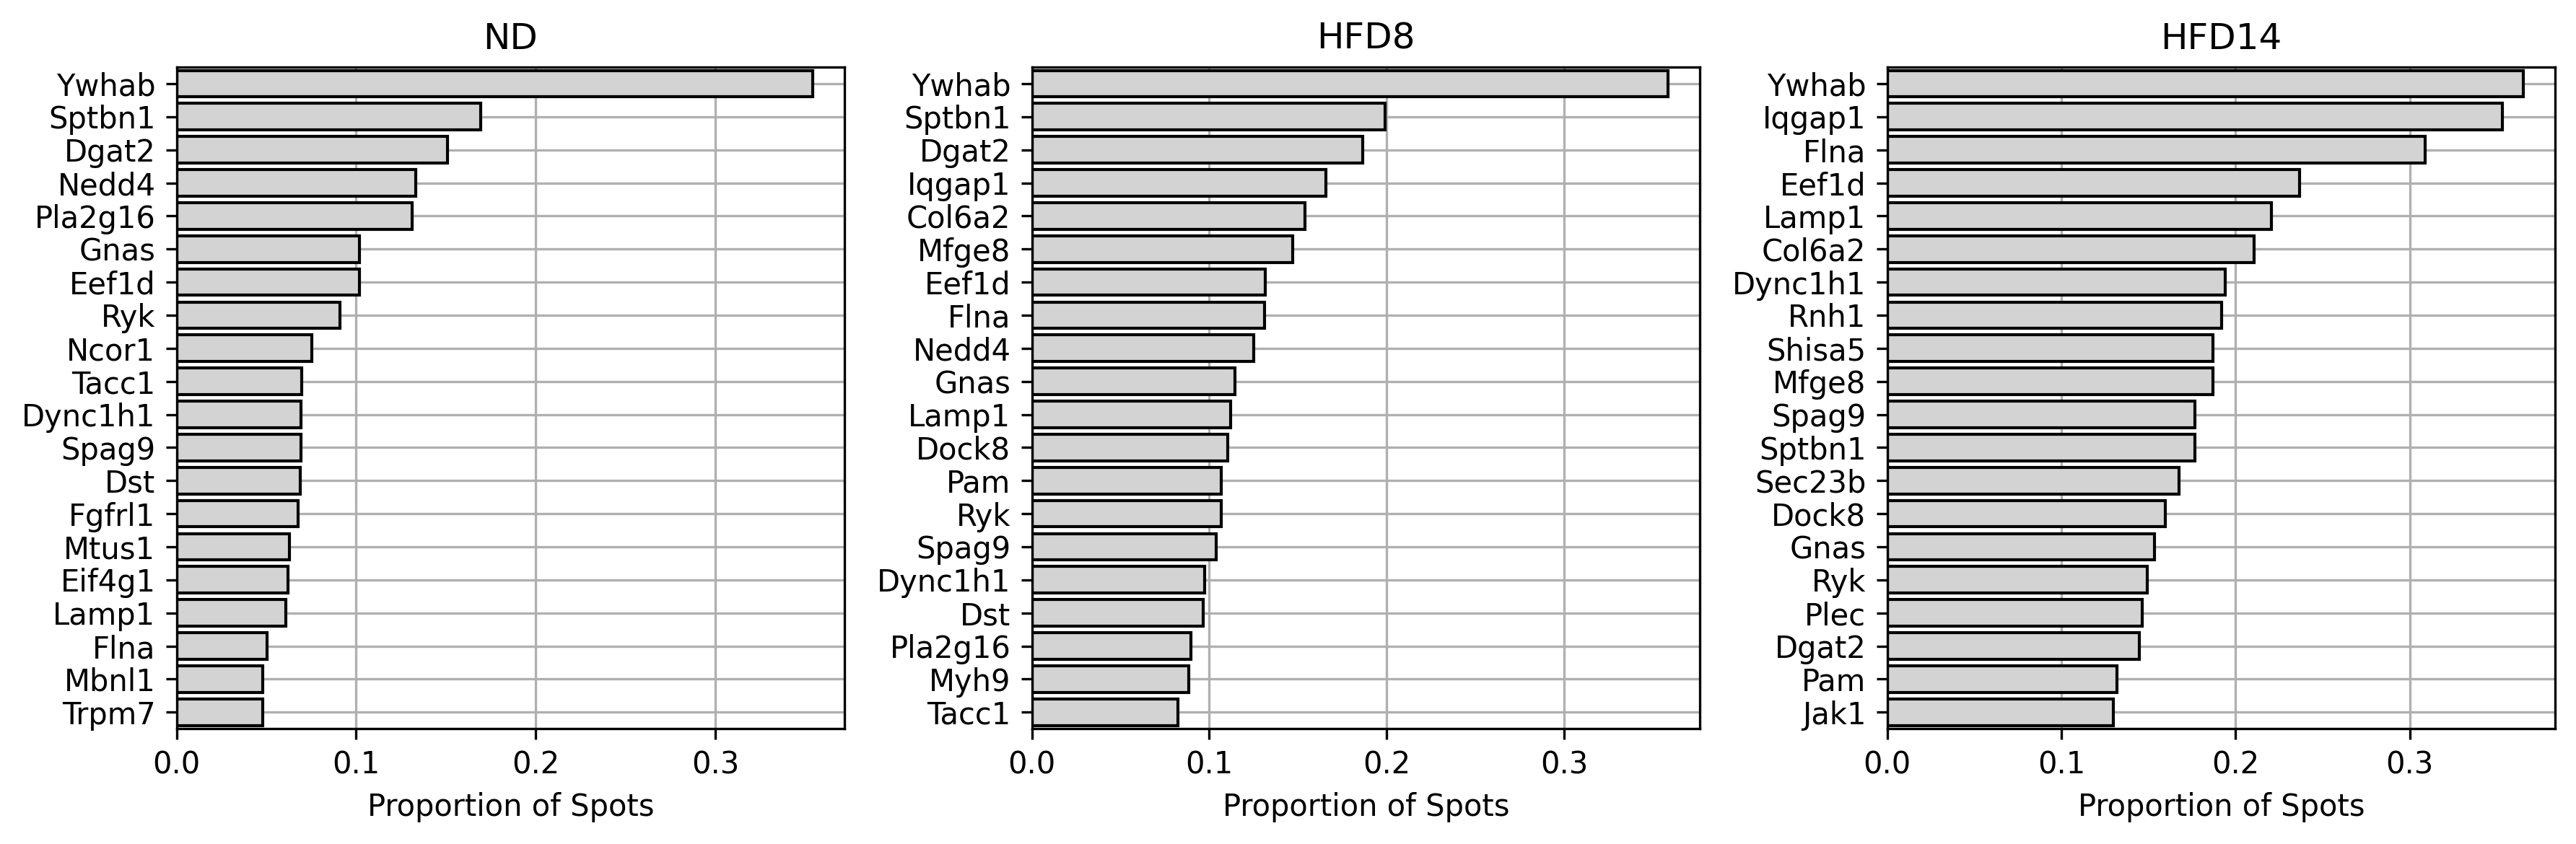

In [12]:
""" plot to most common IRE1 substrates in SPT """

keys = ['ND', 'HFD8', 'HFD14']

top = 20

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 12, 4
plt.rcParams['figure.facecolor'] = "w"


fig, axs = plt.subplots(1, 3)
axs = axs.ravel()
cmap = 'RdYlGn_r'

percExp = {}

for i, key in enumerate(keys):
    kdf = df[df['key'] == key]
    sdf = spt[key]
    
    X = sdf[ire].astype(bool)
    colsums = X.sum(axis=0)
    print(colsums.shape, sdf.shape)
    
    ef = pd.DataFrame({'Gene' : list(colsums.index), 
                       'nSpots' : list(colsums)})
    
    ef['Gene'] = ef['Gene'].apply(lambda x: x.lower().capitalize())
    
    ef['Proportion'] = ef['nSpots'] / sdf.shape[0]
    ef = ef.sort_values(by='Proportion', ascending=False)
    
    percExp[key] = ef
    
    sns.barplot(data=ef.head(top), 
                x='Proportion', 
                y='Gene', 
                color='lightgrey',
                edgecolor='k',
                zorder=2,
                ax=axs[i])
    
    axs[i].set_ylabel("")
    axs[i].set_xlabel("Proportion of Spots")
    axs[i].set_title(key)
    axs[i].grid(True, zorder=1)

plt.tight_layout()

# Spatial Changes in ER Marker Expression

Wed Jan 11 14:05:33 2023 INFO Performing Enichr analysis using database WikiPathways_2019_Mouse.


==== ND vs. HFD8 ====
        Gene  Difference color
365    Mfge8    0.130325     p
361   Iqgap1    0.127571     p
96    Col6a2    0.109597     p
704    Dock8    0.097228     p
381     Flna    0.080524     p
247      Pam    0.071590     p
382    Lamp1    0.051353     p
230   Shisa5    0.050672     p
555     Rnh1    0.045075     p
156     Myh9    0.043696     p
215  Smarca2   -0.008058     o
83      Utrn   -0.008061     o
406    Nedd4   -0.008178     o
448    Ptprm   -0.008646     o
246    Psmd1   -0.012285     o
18      Gys1   -0.012380     o
367    Pde3b   -0.012774     o
251   Atp2b4   -0.016309     o
669    Mtus1   -0.018673     o
760  Pla2g16   -0.041570     o

Upregulated


Wed Jan 11 14:05:33 2023 INFO Performing Enichr analysis using database WikiPathways_2019_Mouse.


| path_name                                     | overlapping_genes    |
|-----------------------------------------------+----------------------|
| G13 Signaling Pathway WP298                   | ROCK1, IQGAP1        |
| Translation Factors WP307                     | EEF1D, EIF4G1        |
| Focal Adhesion WP85                           | ROCK1, COL6A2, FLNA  |
| TNF-alpha NF-kB Signaling Pathway WP246       | DAP, FLNA, SMARCA4   |
| Alpha6-Beta4 Integrin Signaling Pathway WP488 | DST, PLEC            |
| IL-5 Signaling Pathway WP151                  | DNM2, JAK1           |
| PluriNetWork WP1763                           | ROCK1, SMARCA4, JAK1 |
| Statin Pathway WP1                            | LRP1                 |
Downregulated


Wed Jan 11 14:05:34 2023 INFO Performing Enichr analysis using database WikiPathways_2019_Mouse.


| path_name                              | overlapping_genes         |
|----------------------------------------+---------------------------|
| Regulation of Actin Cytoskeleton WP523 | ABI2, PIK3R4, SSH2, MYH10 |
| Insulin Signaling WP65                 | GYS1, PIK3R4, PRKCA       |
| Kit Receptor Signaling Pathway WP407   | PTPRU, PRKCA              |
| Keap1-Nrf2 WP1245                      | PRKCA                     |
==== ND vs. HFD14 ====
        Gene  Difference color
361   Iqgap1    0.314749     p
381     Flna    0.258337     p
365    Mfge8    0.170362     p
555     Rnh1    0.169974     p
96    Col6a2    0.166428     p
382    Lamp1    0.159758     p
230   Shisa5    0.159065     p
704    Dock8    0.146217     p
730    Eef1d    0.135040     p
279   Sec23b    0.127227     p
669    Mtus1   -0.010712     o
764    Hipk2   -0.011302     o
439   Mycbp2   -0.011477     o
448    Ptprm   -0.012677     o
83      Utrn   -0.014750     o
74     Ncor1   -0.018477     o
367    Pde3b   -0.019889

Wed Jan 11 14:05:34 2023 INFO Performing Enichr analysis using database WikiPathways_2019_Mouse.


| path_name                          | overlapping_genes   |
|------------------------------------+---------------------|
| Translation Factors WP307          | EEF1D, EIF4G1       |
| IL-5 Signaling Pathway WP151       | DNM2, JAK1          |
| G Protein Signaling Pathways WP232 | AKAP13, GNAS        |
| Statin Pathway WP1                 | LRP1                |
Downregulated


Wed Jan 11 14:05:35 2023 INFO Performing Enichr analysis using database WikiPathways_2019_Mouse.


| path_name   | overlapping_genes   |
|-------------+---------------------|
==== HFD8 vs. HFD14 ====
        Gene  Difference color
361   Iqgap1    0.187178     p
381     Flna    0.177813     p
555     Rnh1    0.124899     p
382    Lamp1    0.108405     p
230   Shisa5    0.108393     p
730    Eef1d    0.105302     p
76   Dync1h1    0.096557     p
279   Sec23b    0.089718     p
161     Plec    0.081914     p
178    Igf2r    0.074611     p
517    Tcaf1   -0.011096     o
224    Huwe1   -0.012764     o
406    Nedd4   -0.017103     o
74     Ncor1   -0.017284     o
439   Mycbp2   -0.020901     o
98    Sptbn1   -0.022645     o
764    Hipk2   -0.023277     o
242      Dst   -0.025427     o
760  Pla2g16   -0.027885     o
369    Dgat2   -0.041571     o

Upregulated


Wed Jan 11 14:05:35 2023 INFO Performing Enichr analysis using database WikiPathways_2019_Mouse.


| path_name                          | overlapping_genes   |
|------------------------------------+---------------------|
| Translation Factors WP307          | EEF1D, EIF4G1       |
| IL-5 Signaling Pathway WP151       | DNM2, JAK1          |
| G Protein Signaling Pathways WP232 | AKAP13, GNAS        |
| Statin Pathway WP1                 | LRP1                |
Downregulated
| path_name                                     | overlapping_genes   |
|-----------------------------------------------+---------------------|
| Tryptophan metabolism WP79                    | UBR5, UBE3A         |
| Alpha6-Beta4 Integrin Signaling Pathway WP488 | DST, ERBIN          |
| Non-homologous end joining WP1242             | RAD50               |
| NLR Proteins WP1256                           | ERBIN               |
| Homologous recombination WP1258               | RAD50               |
| Adipogenesis genes WP447                      | MBNL1, NCOR1        |


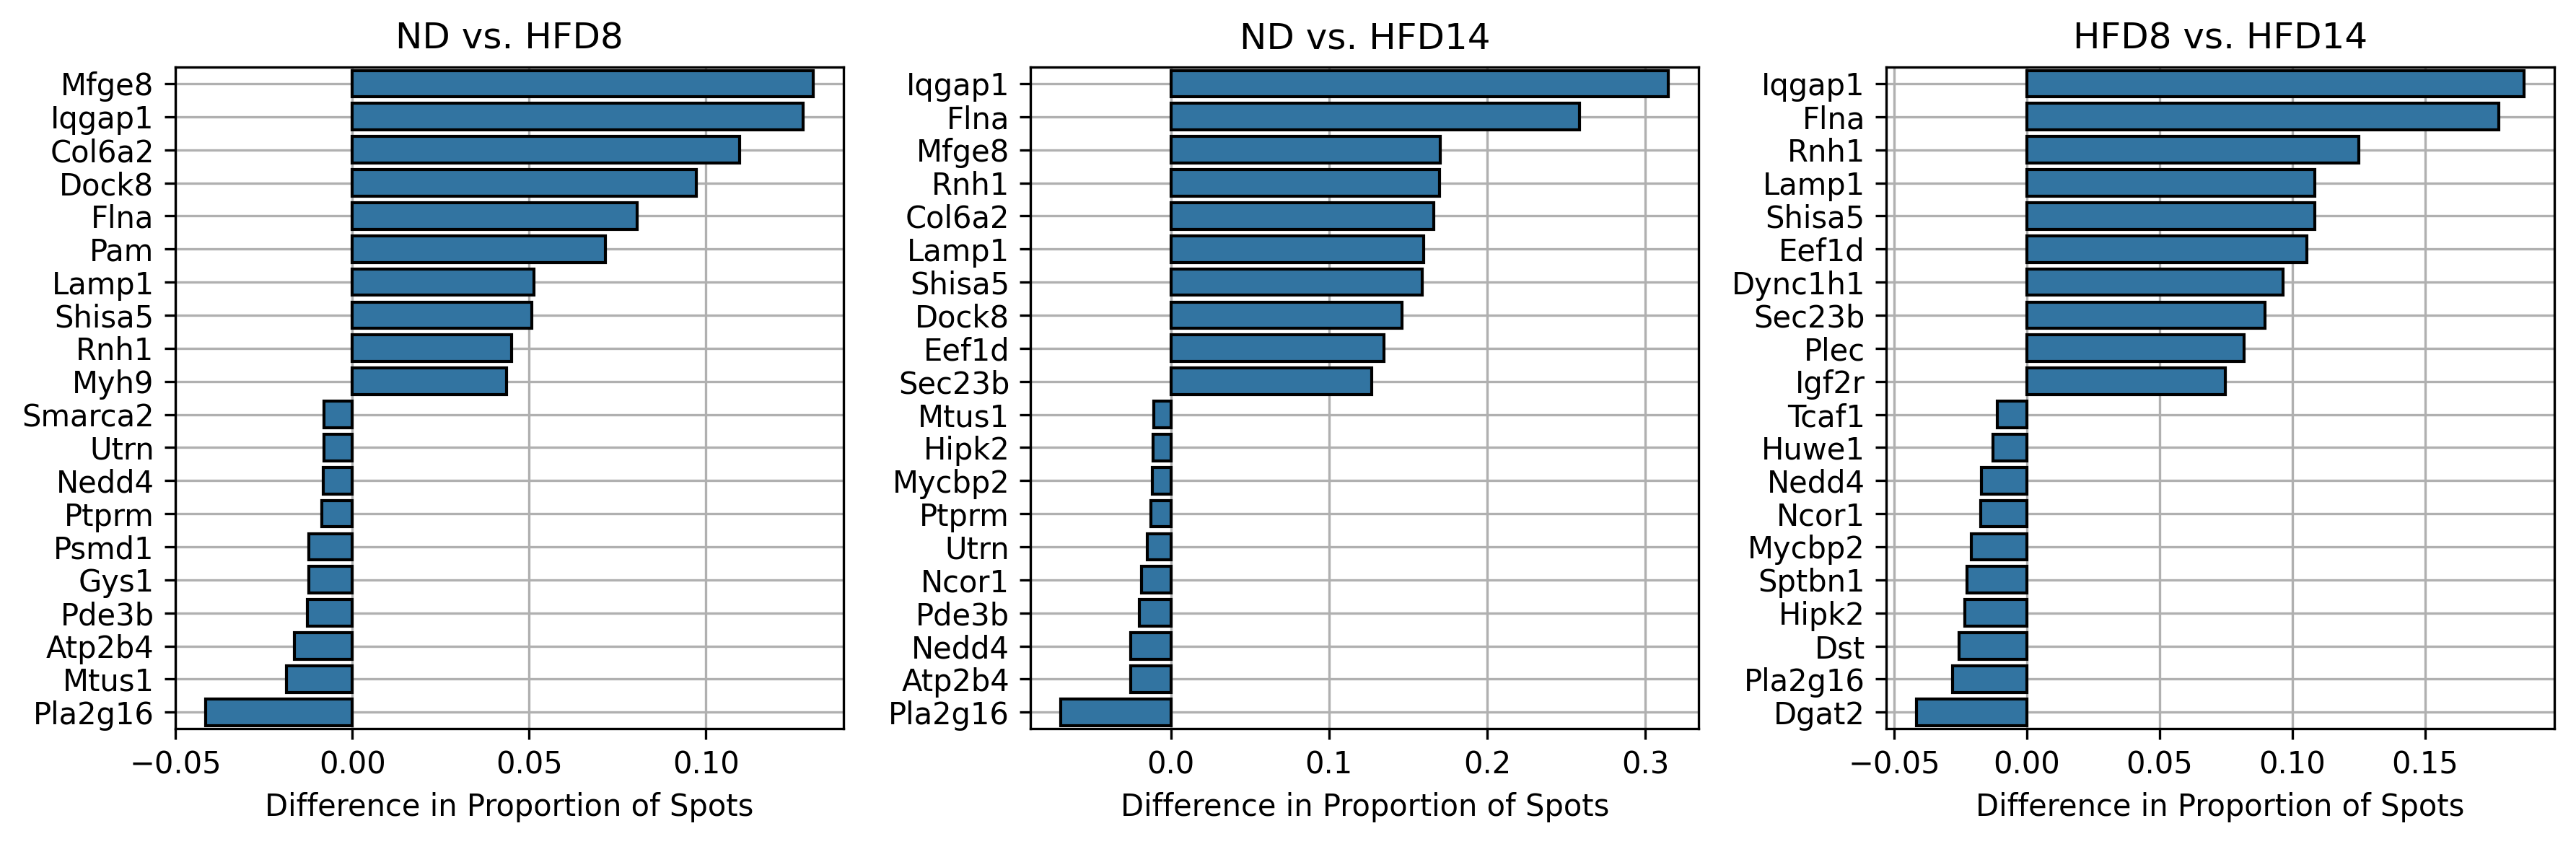

In [13]:
"""GSR for genes expressed in 5% of spots but not in ND """

n = 10
queryN = 50
show = 10
db = 'WikiPathways_2019_Mouse'
# db = 'KEGG_2019_Mouse'
# db = 'ontology'

comps = [
    ('ND', 'HFD8'),
    ('ND', 'HFD14'),
    ('HFD8', 'HFD14'),
]

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 12, 4
plt.rcParams['figure.facecolor'] = "w"

fig, axs = plt.subplots(1, 3)
axs = axs.ravel()

for i, (k1, k2) in enumerate(comps):
    
    k1df = percExp[k1].sort_values(by='Gene')
    k2df = percExp[k2].sort_values(by='Gene')
    
    diffs = k2df['Proportion'] - k1df['Proportion']
    
    ddf = pd.DataFrame({'Gene' : k1df['Gene'], 
                        'Difference' : diffs})

    ddf = ddf.sort_values(by='Difference', ascending=False)

    tb = pd.concat([ddf.head(n), ddf.tail(n)])
    tb['color'] = np.where(tb['Difference'] >= 0, "p", "o")
    
    print(f"==== {k1} vs. {k2} ====")
    print(tb)
    print()
    
    topGenes = ddf['Gene'].head(queryN).to_list()
    bottomGenes = ddf['Gene'].tail(queryN).to_list()
    
    print("Upregulated")
    pd.set_option('display.max_colwidth', 200)
    ef = gget.enrichr(topGenes, database=db)
    ef = ef[ef['p_val'] <= 0.05].reset_index(drop=True)
    printGSR(ef, show)
    
    print("Downregulated")
    pd.set_option('display.max_colwidth', 200)
    ef = gget.enrichr(bottomGenes, database=db)
    ef = ef[ef['p_val'] <= 0.05].reset_index(drop=True)
    printGSR(ef, show)
    

    sns.barplot(data=tb,
                x='Difference', 
                y='Gene', 
                color='C0',
                edgecolor='k',
                zorder=2,
                ax=axs[i])
    
        
    axs[i].set_ylabel("")
    axs[i].set_xlabel("Difference in Proportion of Spots")
    axs[i].set_title(f"{k1} vs. {k2}")
    axs[i].grid(True, zorder=1)

plt.tight_layout()

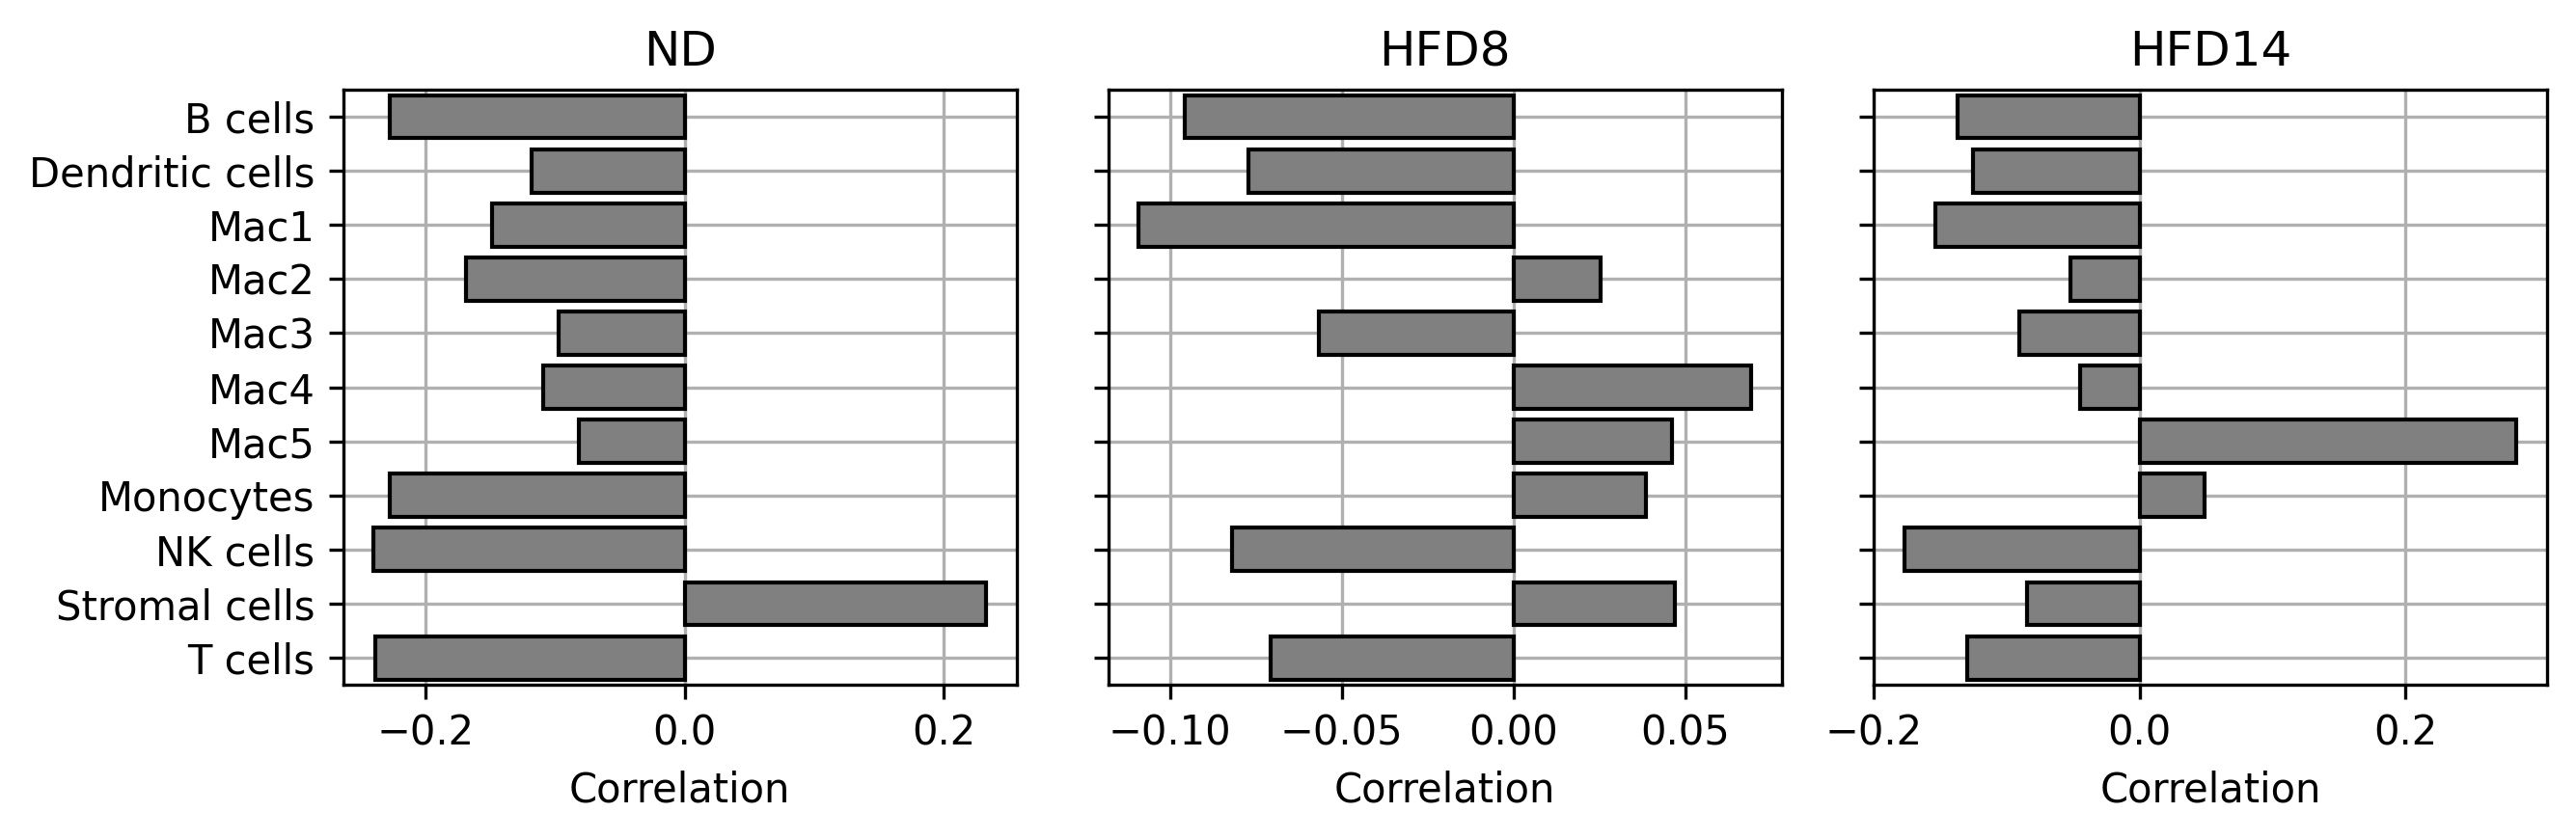

In [14]:
keys = ['ND', 'HFD8', 'HFD14']

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 9, 3
plt.rcParams['figure.facecolor'] = "w"


fig, axs = plt.subplots(1, 3, sharey=True)
axs = axs.ravel()
cmap = 'RdYlGn_r'


for i, key in enumerate(keys):
    kdf = df[df['key'] == key]
    sdf = spt[key]
    
    X = sdf[ire].astype(bool)
    exp = (X.sum(axis=1) / len(X))
    res = []
    
    for cType in cTypes:
        r = scipy.stats.pearsonr(exp, kdf[cType])
        row = {
            'key' : key, 
            'cType' : cType, 
            'r' : r[0],
            'pval' : r[1],
        }
        res.append(row)
        
    res = pd.DataFrame(res)
    res = res.sort_values(by='cType')
    
    sns.barplot(data=res, 
                x='r', 
                y='cType',
                color='grey',
                edgecolor='k',
                zorder=2,
                ax=axs[i])
    
    axs[i].set_xlabel("Correlation")
    axs[i].set_ylabel("")
    axs[i].set_title(key)
    axs[i].grid(zorder=1)

plt.tight_layout()

# DE Analysis of Spots with ER Markers

In [15]:
t = 5 # numbers of ER stress genes expressed 

keys = ['ND', 'HFD8', 'HFD14']

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 3
plt.rcParams['figure.facecolor'] = "w"


colors = ['#9e0142', 
          '#e95c47', 
          '#fdbf6f', 
          '#fdbf6f', 
          '#fdbf6f', 
          '#fdbf6f',  
          '#fdbf6f', # mac5
          '#ffffbe',
          '#bfe5a0', 
          '#54aead',
          '#5e4fa2',
        ]

deg = []

for i, key in enumerate(keys):
    print(f"running {key}....")
    kdf = df[df['key'] == key]
    sdf = spt[key]
    genes = sdf.columns.to_list()
    
    X = sdf[ire].astype(bool)
    rowSums = X.sum(axis=1)
    
    mask = rowSums > t
    
    inGroup = sdf[mask]
    outGroup = sdf[~mask]
    
    spotIds = sdf[mask].index
    spots = kdf[kdf['spotId'].isin(spotIds)]
    
    print(spots[sorted(cTypes)].mean(axis=0), '\n')
    
    for i, g in enumerate(genes):
        
        scores, pvals = stats.ttest_ind_from_stats(
            mean1=inGroup[g].mean(),
            std1=inGroup[g].std(),
            nobs1=inGroup.shape[0],
            mean2=outGroup[g].mean(),
            std2=outGroup[g].std(),
            nobs2=outGroup.shape[0],
            equal_var=False,  # Welch's
        )
        
        lfc =  np.log(inGroup[g].mean()) - np.log(outGroup[g].mean())
        p = inGroup[g].astype(bool).sum() / mask.sum()
        
        isERMarker = False
        if g in ire:
            isERMarker = True
               
        row = {
            'key' : key,
            'gene' : g,
            'pval' : pvals,
            'logfoldchange' : lfc,
            'meanGroup' : inGroup[g].mean(),
            'meanOther' : outGroup[g].mean(),
            'isERMarker' : isERMarker,
            'percExp' : p,
        }
        
        deg.append(row)
    
deg = pd.DataFrame(deg)
print(f"{deg.shape=}")
deg.head()

running ND....
B cells            0.007689
Dendritic cells    0.004239
Mac1               0.018887
Mac2               0.015674
Mac3               0.004098
Mac4               0.031224
Mac5               0.040098
Monocytes          0.019520
NK cells           0.015815
Stromal cells      0.831468
T cells            0.011289
dtype: float64 



/tmp/ipykernel_2785556/1563029779.py:56: RuntimeWarning: divide by zero encountered in log
  lfc =  np.log(inGroup[g].mean()) - np.log(outGroup[g].mean())
/tmp/ipykernel_2785556/1563029779.py:56: RuntimeWarning: invalid value encountered in double_scalars
  lfc =  np.log(inGroup[g].mean()) - np.log(outGroup[g].mean())


running HFD8....
B cells            0.057731
Dendritic cells    0.013940
Mac1               0.029804
Mac2               0.042006
Mac3               0.022455
Mac4               0.115456
Mac5               0.128520
Monocytes          0.039777
NK cells           0.027777
Stromal cells      0.501005
T cells            0.021529
dtype: float64 



/tmp/ipykernel_2785556/1563029779.py:56: RuntimeWarning: divide by zero encountered in log
  lfc =  np.log(inGroup[g].mean()) - np.log(outGroup[g].mean())
/tmp/ipykernel_2785556/1563029779.py:56: RuntimeWarning: invalid value encountered in double_scalars
  lfc =  np.log(inGroup[g].mean()) - np.log(outGroup[g].mean())


running HFD14....
B cells            0.041227
Dendritic cells    0.022671
Mac1               0.033888
Mac2               0.027161
Mac3               0.024937
Mac4               0.027106
Mac5               0.335335
Monocytes          0.086357
NK cells           0.083710
Stromal cells      0.278794
T cells            0.038813
dtype: float64 



/tmp/ipykernel_2785556/1563029779.py:56: RuntimeWarning: divide by zero encountered in log
  lfc =  np.log(inGroup[g].mean()) - np.log(outGroup[g].mean())
/tmp/ipykernel_2785556/1563029779.py:56: RuntimeWarning: invalid value encountered in double_scalars
  lfc =  np.log(inGroup[g].mean()) - np.log(outGroup[g].mean())


deg.shape=(93159, 8)


,key,gene,pval,logfoldchange,meanGroup,meanOther,isERMarker,percExp
0,ND,XKR4,0.157406,inf,0.002049,0.00000,False,0.002049
1,ND,GM1992,NaN,NaN,0.000000,0.00000,False,0.000000
2,ND,GM37381,NaN,NaN,0.000000,0.00000,False,0.000000
3,ND,RP1,NaN,NaN,0.000000,0.00000,False,0.000000
4,ND,SOX17,0.076618,0.929859,0.014344,0.00566,False,0.012295


In [16]:
n = 5
show = 10
alpha = 0.05
nGene = 100

# db = 'WikiPathways_2019_Mouse'
# db = 'KEGG_2019_Mouse'
db = 'ontology'

for i, key in enumerate(keys):
    
    cdf = deg[deg['key'] == key]
    cdf = cdf[~cdf.isin([np.nan, np.inf, -np.inf]).any(1)]
    cdf = cdf[cdf['pval'] <= alpha]
    print(f"{key} {cdf.shape=}")
    
    cdf['score'] = cdf['logfoldchange'] * cdf['percExp']
    cdf = cdf.sort_values(by='score', ascending=False) 
    print(f"==== {key} ====")
    print(cdf[['gene', 'logfoldchange', 'meanGroup', 'meanOther', 'percExp', 'isERMarker']].head(show), '\n')
    
    query  = deg['gene'].head(nGene).to_list()
    
    pd.set_option('display.max_colwidth', 200)
    ef = gget.enrichr(query, database=db)
    ef = ef[ef['p_val'] <= alpha].reset_index(drop=True)
    printGSR(ef, show)
    print()
    
    
    
    # break
    

/tmp/ipykernel_2785556/2526989363.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  cdf = cdf[~cdf.isin([np.nan, np.inf, -np.inf]).any(1)]
Wed Jan 11 14:07:09 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


ND cdf.shape=(2890, 8)
==== ND ====
        gene  logfoldchange  meanGroup  meanOther   percExp  isERMarker
5223   FABP4       1.293214  15.544057   4.265094  0.991803       False
5241    CAR3       1.119008   7.619877   2.488679  0.970287       False
15279    CFD       1.029593  14.316598   5.113208  0.994877       False
9975    ACTB       1.145989   3.032787   0.964151  0.788934       False
3775   YWHAB       1.505302   0.973361   0.216038  0.553279        True
30792   SCD1       0.801143   6.078893   2.728302  0.943648       False
19934   RPL4       1.136948   1.382172   0.443396  0.646516       False
16672    LPL       1.154084   1.343238   0.423585  0.635246       False
2208     GSN       1.035220   1.577869   0.560377  0.673156       False
8458    CD36       1.164204   1.257172   0.392453  0.568648       False 



/tmp/ipykernel_2785556/2526989363.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  cdf = cdf[~cdf.isin([np.nan, np.inf, -np.inf]).any(1)]
Wed Jan 11 14:07:09 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


| path_name                                                                                    | overlapping_genes    |
|----------------------------------------------------------------------------------------------+----------------------|
| nuclear cell cycle DNA replication initiation (GO:1902315)                                   | MCMDC2, MCM3         |
| mitotic DNA replication initiation (GO:1902975)                                              | MCMDC2, MCM3         |
| pre-replicative complex assembly involved in nuclear cell cycle DNA replication (GO:0006267) | MCMDC2, MCM3         |
| interleukin-17-mediated signaling pathway (GO:0097400)                                       | IL17F, IL17A         |
| cellular response to interleukin-17 (GO:0097398)                                             | IL17F, IL17A         |
| mitotic DNA replication (GO:1902969)                                                         | MCMDC2, MCM3         |
| nuclear DNA replication (GO:0033260)  

/tmp/ipykernel_2785556/2526989363.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  cdf = cdf[~cdf.isin([np.nan, np.inf, -np.inf]).any(1)]
Wed Jan 11 14:07:10 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


| path_name                                                                                    | overlapping_genes    |
|----------------------------------------------------------------------------------------------+----------------------|
| nuclear cell cycle DNA replication initiation (GO:1902315)                                   | MCMDC2, MCM3         |
| mitotic DNA replication initiation (GO:1902975)                                              | MCMDC2, MCM3         |
| pre-replicative complex assembly involved in nuclear cell cycle DNA replication (GO:0006267) | MCMDC2, MCM3         |
| interleukin-17-mediated signaling pathway (GO:0097400)                                       | IL17F, IL17A         |
| cellular response to interleukin-17 (GO:0097398)                                             | IL17F, IL17A         |
| mitotic DNA replication (GO:1902969)                                                         | MCMDC2, MCM3         |
| nuclear DNA replication (GO:0033260)  

# Radius Around Spots with ER Markers

In [17]:
"""Same as above, but with a neighborhood """
t = 25
k = 6

deg = []

for i, key in enumerate(keys):
    print(f"running {key}....")
    kdf = df[df['key'] == key]
    sdf = spt[key]
    genes = sdf.columns.to_list()
    
    X = sdf[ire].astype(bool).sum(axis=1)
    mask = X > t
    
    print(f"{mask.sum()} ({mask.sum()/len(mask):.3f}) {key} spots have > {t} ER genes")
    
    X = kdf[['spotId', 'x', 'y']]
    X = X.set_index('spotId')
    
    tree = BallTree(X, leaf_size=10, metric='euclidean')
    dist, ind = tree.query(X[mask], k=k)
    
    indx = np.unique(np.ravel(ind))
    
    print(f"{len(indx)} ({len(indx) / len(mask):.3f}) are within {k} neigherbors of query spots")
    spotIds = X.index[indx]

    spots = kdf[kdf['spotId'].isin(spotIds)]
    print(spots[sorted(cTypes)].mean(axis=0), '\n')
    
    inGroup = sdf[sdf.index.isin(spotIds)]
    outGroup = sdf[~sdf.index.isin(spotIds)]
    
    for i, g in enumerate(genes):
        
        scores, pvals = stats.ttest_ind_from_stats(
            mean1=inGroup[g].mean(),
            std1=inGroup[g].std(),
            nobs1=inGroup.shape[0],
            mean2=outGroup[g].mean(),
            std2=outGroup[g].std(),
            nobs2=outGroup.shape[0],
            equal_var=False,  # Welch's
        )
        
        lfc =  np.log(inGroup[g].mean()) - np.log(outGroup[g].mean())
        p = inGroup[g].astype(bool).sum() / len(spotIds)
        
        isERMarker = False
        if g in ire:
            isERMarker = True
               
        row = {
            'key' : key,
            'gene' : g,
            'pval' : pvals,
            'logfoldchange' : lfc,
            'meanGroup' : inGroup[g].mean(),
            'meanOther' : outGroup[g].mean(),
            'isERMarker' : isERMarker,
            'percExp' : p,
        }
        
        deg.append(row)
    
deg = pd.DataFrame(deg)
print(f"{deg.shape=}")
deg.head()

running ND....
17 (0.008) ND spots have > 25 ER genes
98 (0.048) are within 6 neigherbors of query spots
B cells            0.008034
Dendritic cells    0.005678
Mac1               0.028471
Mac2               0.018685
Mac3               0.006026
Mac4               0.034217
Mac5               0.049686
Monocytes          0.021704
NK cells           0.017427
Stromal cells      0.787603
T cells            0.012265
dtype: float64 



/tmp/ipykernel_2785556/2069114747.py:47: RuntimeWarning: divide by zero encountered in log
  lfc =  np.log(inGroup[g].mean()) - np.log(outGroup[g].mean())
/tmp/ipykernel_2785556/2069114747.py:47: RuntimeWarning: invalid value encountered in double_scalars
  lfc =  np.log(inGroup[g].mean()) - np.log(outGroup[g].mean())


running HFD8....
319 (0.094) HFD8 spots have > 25 ER genes
1319 (0.389) are within 6 neigherbors of query spots
B cells            0.057931
Dendritic cells    0.018204
Mac1               0.035774
Mac2               0.045072
Mac3               0.026845
Mac4               0.116045
Mac5               0.139040
Monocytes          0.043073
NK cells           0.031075
Stromal cells      0.462244
T cells            0.024695
dtype: float64 



/tmp/ipykernel_2785556/2069114747.py:47: RuntimeWarning: divide by zero encountered in log
  lfc =  np.log(inGroup[g].mean()) - np.log(outGroup[g].mean())
/tmp/ipykernel_2785556/2069114747.py:47: RuntimeWarning: invalid value encountered in double_scalars
  lfc =  np.log(inGroup[g].mean()) - np.log(outGroup[g].mean())


running HFD14....
285 (0.143) HFD14 spots have > 25 ER genes
1072 (0.538) are within 6 neigherbors of query spots
B cells            0.037612
Dendritic cells    0.023737
Mac1               0.034223
Mac2               0.026955
Mac3               0.026166
Mac4               0.027547
Mac5               0.362168
Monocytes          0.086194
NK cells           0.078780
Stromal cells      0.259336
T cells            0.036349
dtype: float64 



/tmp/ipykernel_2785556/2069114747.py:47: RuntimeWarning: divide by zero encountered in log
  lfc =  np.log(inGroup[g].mean()) - np.log(outGroup[g].mean())
/tmp/ipykernel_2785556/2069114747.py:47: RuntimeWarning: invalid value encountered in double_scalars
  lfc =  np.log(inGroup[g].mean()) - np.log(outGroup[g].mean())


deg.shape=(93159, 8)


,key,gene,pval,logfoldchange,meanGroup,meanOther,isERMarker,percExp
0,ND,XKR4,0.157353,-inf,0.0,0.001032,False,0.0
1,ND,GM1992,NaN,NaN,0.0,0.000000,False,0.0
2,ND,GM37381,NaN,NaN,0.0,0.000000,False,0.0
3,ND,RP1,NaN,NaN,0.0,0.000000,False,0.0
4,ND,SOX17,0.000043,-inf,0.0,0.010320,False,0.0


In [18]:
n = 5
show = 10
alpha = 0.05
nGene = 10

# db = 'WikiPathways_2019_Mouse'
# db = 'KEGG_2019_Mouse'
db = 'ontology'

for i, key in enumerate(keys):
    
    cdf = deg[deg['key'] == key]
    cdf = cdf[~cdf.isin([np.nan, np.inf, -np.inf]).any(1)]
    cdf = cdf[cdf['pval'] <= alpha]
    print(f"{key} {cdf.shape=}")
    
    cdf['score'] = cdf['logfoldchange'] * cdf['percExp']
    cdf = cdf.sort_values(by='score', ascending=False) 
    print(f"==== {key} ====")
    print(cdf[['gene', 'logfoldchange', 'meanGroup', 'meanOther', 'percExp', 'isERMarker']].head(show), '\n')
    
    query  = deg['gene'].head(nGene).to_list()
    
    pd.set_option('display.max_colwidth', 200)
    ef = gget.enrichr(query, database=db)
    ef = ef[ef['p_val'] <= alpha].reset_index(drop=True)
    printGSR(ef, show)
    print()


/tmp/ipykernel_2785556/3831780742.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  cdf = cdf[~cdf.isin([np.nan, np.inf, -np.inf]).any(1)]
Wed Jan 11 14:08:35 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


ND cdf.shape=(177, 8)
==== ND ====
        gene  logfoldchange  meanGroup  meanOther   percExp  isERMarker
9975    ACTB       1.153464   5.612245   1.770898  0.846939       False
19934   RPL4       0.769379   1.826531   0.846233  0.683673       False
8458    CD36       0.785189   1.673469   0.763158  0.489796       False
5241    CAR3       0.412526   7.295918   4.829721  0.908163       False
15264    BSG       0.777464   0.693878   0.318885  0.469388       False
5223   FABP4       0.386436  13.918367   9.457172  0.938776       False
30388   FTH1       0.821621   0.704082   0.309598  0.428571       False
9997    RAC1       0.896564   0.602041   0.245614  0.387755       False
2939     CAT       0.827445   0.632653   0.276574  0.387755       False
2208     GSN       0.511659   1.693878   1.015480  0.622449       False 



/tmp/ipykernel_2785556/3831780742.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  cdf = cdf[~cdf.isin([np.nan, np.inf, -np.inf]).any(1)]
Wed Jan 11 14:08:35 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


| path_name                                                  | overlapping_genes   |
|------------------------------------------------------------+---------------------|
| endocardial cell differentiation (GO:0060956)              | SOX17               |
| endodermal cell fate specification (GO:0001714)            | SOX17               |
| cardiac cell fate commitment (GO:0060911)                  | SOX17               |
| cardiac endothelial cell differentiation (GO:0003348)      | SOX17               |
| retinal cone cell development (GO:0046549)                 | RP1                 |
| retinal cone cell differentiation (GO:0042670)             | RP1                 |
| photoreceptor cell outer segment organization (GO:0035845) | RP1                 |
| retinal rod cell development (GO:0046548)                  | RP1                 |
| ureter development (GO:0072189)                            | SOX17               |
| photoreceptor cell differentiation (GO:0046530)            | RP

/tmp/ipykernel_2785556/3831780742.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  cdf = cdf[~cdf.isin([np.nan, np.inf, -np.inf]).any(1)]
Wed Jan 11 14:08:36 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


| path_name                                                  | overlapping_genes   |
|------------------------------------------------------------+---------------------|
| endocardial cell differentiation (GO:0060956)              | SOX17               |
| endodermal cell fate specification (GO:0001714)            | SOX17               |
| cardiac cell fate commitment (GO:0060911)                  | SOX17               |
| cardiac endothelial cell differentiation (GO:0003348)      | SOX17               |
| retinal cone cell development (GO:0046549)                 | RP1                 |
| retinal cone cell differentiation (GO:0042670)             | RP1                 |
| photoreceptor cell outer segment organization (GO:0035845) | RP1                 |
| retinal rod cell development (GO:0046548)                  | RP1                 |
| ureter development (GO:0072189)                            | SOX17               |
| photoreceptor cell differentiation (GO:0046530)            | RP

In [19]:
# break

In [20]:
# keys = ['ND', 'HFD8', 'HFD14']

# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.figsize'] = 18, 4
# plt.rcParams['figure.facecolor'] = "w"


# fig, axs = plt.subplots(1, 3, sharey=True)
# axs = axs.ravel()
# cmap = 'RdYlGn_r'
# tRange = np.linspace(0, 75, 21).astype(int)


# for i, key in enumerate(keys):
#     kdf = df[df['key'] == key]
#     sdf = spt[key]
#     lrdf = lrData[key]
    
#     rowSum = sdf[ire].astype(bool).sum(axis=1) 
    
#     res = []
    
#     for t in tRange:
#         mask = (rowSum > t)
#         spotIds = sdf[mask].index
#         spots = kdf[kdf['spotId'].isin(spotIds)]

#         props = pd.DataFrame(spots[cTypes].mean(axis=0))
#         props['t'] = t
#         res.append(props)

        
#     res = pd.concat(res)
#     res = res.reset_index(drop=False)
#     res.columns = ['cellType', 'proportion', 'threshold']
    
#     res2 = pd.pivot_table(res, 
#                           values='proportion', 
#                           index=['cellType'], 
#                           columns='threshold').reset_index()
    
#     color = ['#9e0142', 
#              '#e95c47', 
#              '#fdbf6f', 
#              '#fdd26f',
#              '#fdbf6f',
#              '#fdbf6f', 
#              'r', # mac5
#              '#ffffbe',
#              '#bfe5a0', 
#              '#54aead',
#              '#5e4fa2',
#         ]

#     res2 = res2.set_index('cellType')
#     res2.T.plot(kind='bar', 
#                 stacked=True, 
#                 edgecolor='k', 
#                 ax=axs[i], 
#                 legend=False,
#                 color=color)
    
    
#     handles = []
    
#     for ic, ctype in enumerate(sorted(cTypes)):
        
#         handle = mpatches.Patch(color=color[ic], 
#                                 ec='k', 
#                                 label=ctype)
#         handles.append(handle)
        
#     axs[i].set_ylabel('Proportion of Spot')
#     axs[i].tick_params(labelrotation=0)
#     axs[i].set_xlabel("Threshold")
#     axs[i].set_title(key)
    

# plt.legend(handles=handles, bbox_to_anchor=(1.04, 1.02))
# plt.tight_layout()    

# LR Expression at Spots with High ER Stress Signal

==== ND ====
                 LR  Proportion
98          C3-Cd81    0.309524
15        Cdh5-Cdh5    0.190476
116      Gnas-Adrb3    0.166667
52        Mcam-Mcam    0.142857
19      Col1a1-Cd36    0.119048
20      Col1a2-Cd36    0.095238
100         C3-Lrp1    0.095238
50         Lpl-Lrp1    0.095238
1    Adipoq-Adipor2    0.071429
62      Ptprm-Ptprm    0.071429
88         Cav1-App    0.071429
81         App-Cav1    0.071429
80      Aplp2-H2-D1    0.047619
60        Psap-Lrp1    0.047619
59    Pecam1-Pecam1    0.047619

['C3', 'Cd81', 'Cdh5', 'Cdh5', 'Gnas', 'Adrb3', 'Mcam', 'Mcam', 'Col1a1', 'Cd36', 'Col1a2', 'Cd36', 'C3', 'Lrp1', 'Lpl', 'Lrp1', 'Adipoq', 'Adipor2', 'Ptprm', 'Ptprm', 'Cav1', 'App', 'App', 'Cav1', 'Aplp2', 'H2', 'D1', 'Psap', 'Lrp1', 'Pecam1', 'Pecam1']
==== HFD8 ====
              LR  Proportion
35   Col1a1-Cd36    0.384279
202      C3-Cd81    0.323144
40   Col1a2-Cd36    0.216157
89      Lpl-Lrp1    0.157205
170     Cav1-App    0.141921
159     App-Cav1    0.141921
1

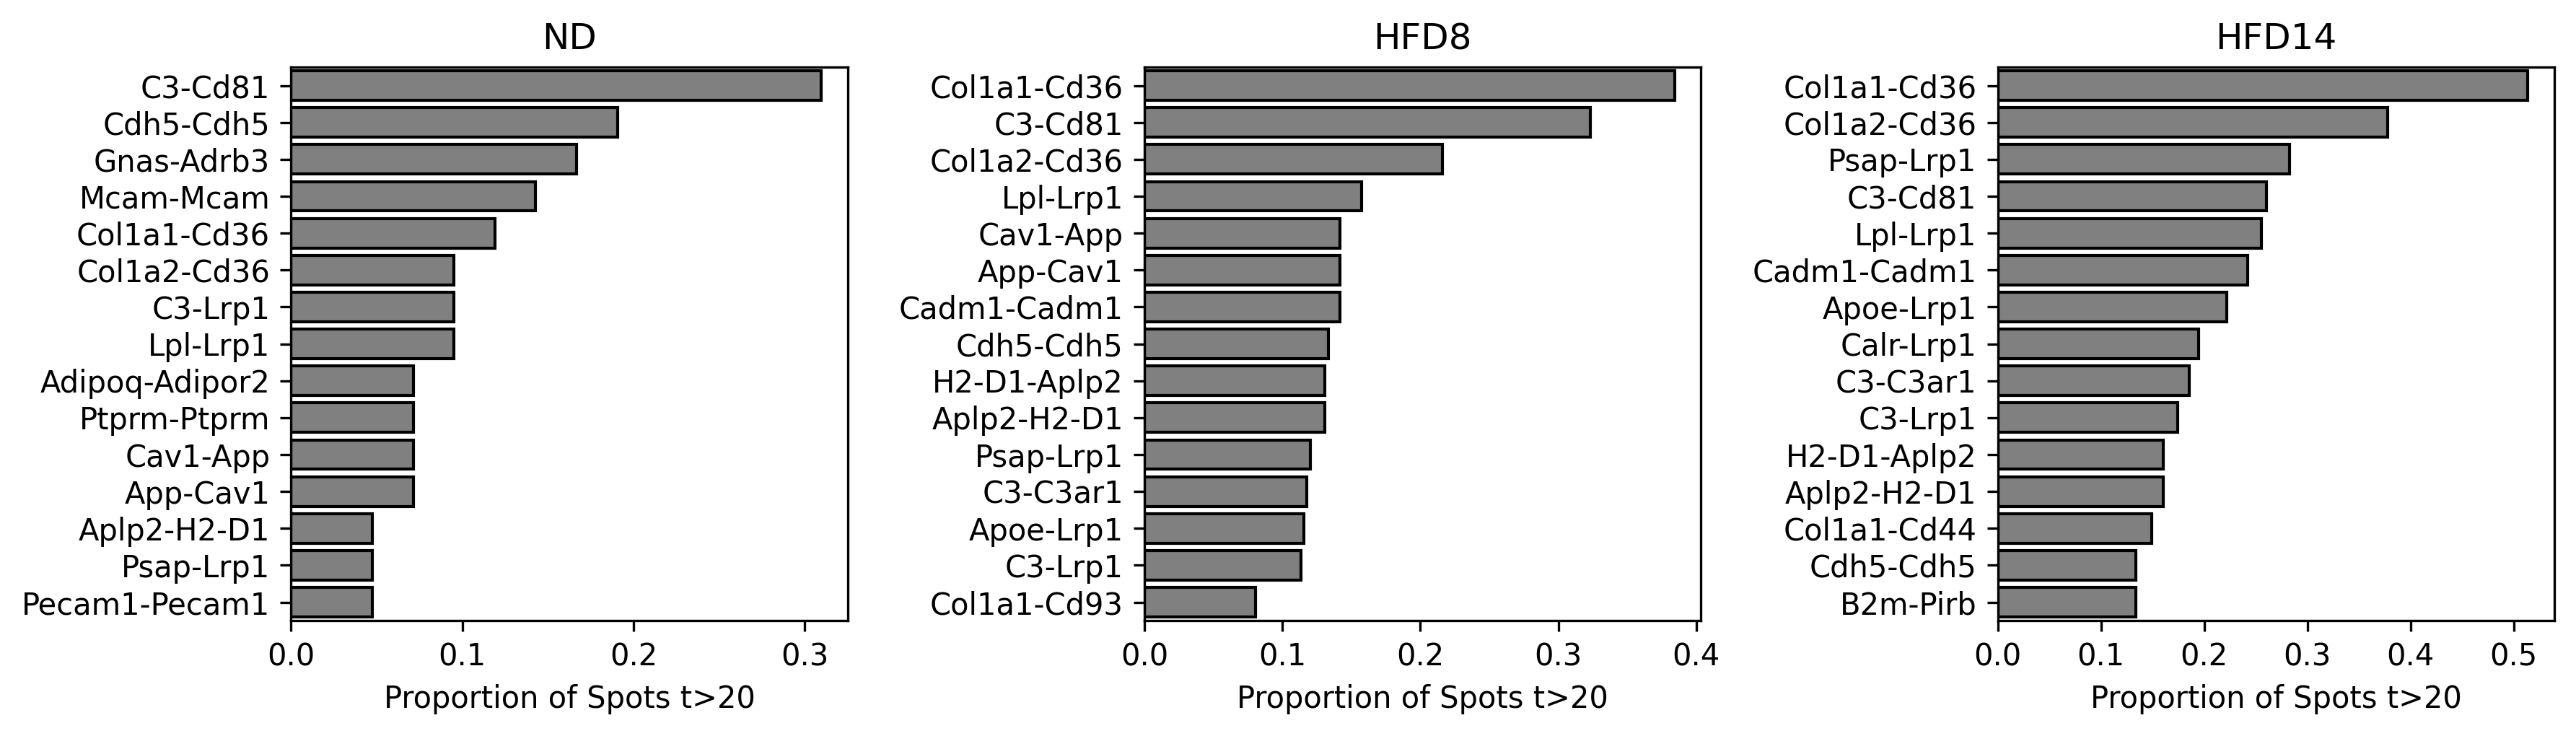

In [21]:
keys = ['ND', 'HFD8', 'HFD14']

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 12, 3.5
plt.rcParams['figure.facecolor'] = "w"

def flatten(l):
    return [item for sublist in l for item in sublist]


fig, axs = plt.subplots(1, 3, sharey=False)
axs = axs.ravel()

t = 20
n = 15

lrExpDf = {}


for i, key in enumerate(keys):
    kdf = df[df['key'] == key]
    sdf = spt[key]
    lrdf = lrData[key]
    
    rowSum = sdf[ire].astype(bool).sum(axis=1) 
    mask = (rowSum > t)
    
    spotIds = sdf[mask].index
    ldfBool = lrdf[lrdf.index.isin(spotIds)].astype(bool)
    
    colSumns = ldfBool.sum(axis=0)
    prop = colSumns / len(ldfBool)
    prop = pd.DataFrame(prop)
    prop = prop.reset_index(drop=False)
    prop.columns = ['LR', 'Proportion']
    prop = prop.sort_values(by='Proportion', ascending=False)
    
    lrExpDf[key] = prop
    print(f"==== {key} ====")
    print(prop.head(n))
    
    print()
    lrList = [x.split("-") for x in prop['LR'].head(n)]
    print(flatten(lrList))
    
    sns.barplot(data=prop.head(n),
                y='LR', 
                x='Proportion', 
                color='grey',
                edgecolor='k',
                ax=axs[i])
        
    axs[i].set_ylabel("")
    axs[i].set_xlabel(f"Proportion of Spots t>{t}")
    axs[i].set_title(key)

plt.tight_layout()

# Time Series Compairison for LR pairs at ER spots

Wed Jan 11 15:12:19 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


==== ND vs. HFD8 ====
               LR  Difference
35      Gjc1-Gjc1    0.360470
40    Igfbp4-Lrp6    0.216157
13    Cdh13-Cdh13    0.141921
89       Cd74-App    0.133396
28       Dcn-Egfr    0.133188
110     C4b-C3ar1    0.120087
4       Apoe-Lrp5    0.091911
36      Gpc3-Cd81    0.067686
37      Gpi1-Amfr    0.056977
68   Tgfb1-Tgfbr3    0.056769
81       App-Cav1   -0.058328
62    Ptprm-Ptprm   -0.069245
50       Lpl-Lrp1   -0.088688
20    Col1a2-Cd36   -0.090871
100       C3-Lrp1   -0.093055
19    Col1a1-Cd36   -0.112497
52      Mcam-Mcam   -0.140674
116    Gnas-Adrb3   -0.160116
15      Cdh5-Cdh5   -0.188293
98        C3-Cd81   -0.307340

Upregulated


Wed Jan 11 15:12:19 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


| path_name                                                         | overlapping_genes                                                                                                                          |
|-------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------|
| positive regulation of cell population proliferation (GO:0008284) | PDGFRB, CD74, TGFB1, NOTCH1, CD81, WNT5A, LRP5, THBS1, FGF2, BMP6, EGFR, TSHR, VEGFA, AQP1, GNAI2, TGFBR3, CDH13, CALR, FGFR3, FGFR1       |
| regulation of cell migration (GO:0030334)                         | ACVR1, PDGFRB, CD74, TGFB1, ANXA1, JAG1, NOTCH1, SEMA3C, PTPRK, SORL1, THBS1, FGF2, EGFR, VEGFA, ROBO1, CEACAM1, DAG1, CDH13               |
| regulation of ERK1 and ERK2 cascade (GO:0070372)                  | PDGFRB, NOTCH2, CD74, APP, NRP1, TGFB1, NOTCH1, FGF2, EGFR, TGFBR3, CEACAM1, APOE, TLR

Wed Jan 11 15:12:20 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


| path_name                                                            | overlapping_genes                                                                                      |
|----------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------|
| extracellular structure organization (GO:0043062)                    | ITGB1, APP, COL18A1, LAMB2, MMP2, FN1, THBS1, FGF2, COL1A1, COL1A2, COL5A1, COL4A1, PECAM1, CD47, CD44 |
| external encapsulating structure organization (GO:0045229)           | ITGB1, APP, COL18A1, LAMB2, MMP2, FN1, THBS1, FGF2, COL1A1, COL1A2, COL5A1, COL4A1, PECAM1, CD47, CD44 |
| extracellular matrix organization (GO:0030198)                       | ITGB1, APP, COL18A1, LAMB2, MMP2, FN1, THBS1, FGF2, COL1A1, COL1A2, COL5A1, COL4A1, PECAM1, CD47, CD44 |
| positive regulation of metabolic process (GO:0009893)                | GJA1, ADRB3, CAV1, INSR, ADIPOQ, GNAS

Wed Jan 11 15:12:20 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


| path_name                                                         | overlapping_genes                                                                                                               |
|-------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------|
| regulation of cell migration (GO:0030334)                         | PDGFRB, TGFB1, ANXA1, JAG1, FLT1, SEMA3C, INSR, LAMB1, PTPRK, IGF1, SORL1, THBS1, FGF2, EGFR, VEGFA, ROBO1, CEACAM1, DAG1       |
| positive regulation of MAPK cascade (GO:0043410)                  | PDGFRB, NOTCH2, APP, NRP1, TGFB1, FLT1, INSR, IGF1, FGF2, EGFR, VEGFA, ROBO1, CD36, APOE, FGFR3                                 |
| positive regulation of cellular process (GO:0048522)              | PDGFRB, TGFB1, FLT1, LRP1, CD81, INSR, WNT5A, IGF1, THBS1, FGF2, EGFR, TSHR, VEGFA, LRP6, GNAI2, SIRPA, CD36, CD47, TLR4, FGFR3 |


Wed Jan 11 15:12:21 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


| path_name                                                              | overlapping_genes                                                                                      |
|------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------|
| extracellular structure organization (GO:0043062)                      | ITGB1, APP, COL18A1, MMP2, FN1, THBS1, FGF2, COL1A1, COL1A2, COL5A1, COL4A1, PECAM1, CD47, CD44        |
| external encapsulating structure organization (GO:0045229)             | ITGB1, APP, COL18A1, MMP2, FN1, THBS1, FGF2, COL1A1, COL1A2, COL5A1, COL4A1, PECAM1, CD47, CD44        |
| positive regulation of multicellular organismal process (GO:0051240)   | CADM1, LRP1, CAV1, ADIPOQ, ADIPOR1, ADIPOR2, FGF2, TSHR, COL1A1, GJA1, ADRB3, GNAS, CD36, APOE, CMKLR1 |
| extracellular matrix organization (GO:0030198)                         | ITGB1, APP, COL18A1, MMP2

Wed Jan 11 15:12:21 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


| path_name                                                         | overlapping_genes                                                                                                           |
|-------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------|
| extracellular matrix organization (GO:0030198)                    | DDR1, APP, COL14A1, FN1, ADAM10, HSPG2, THBS1, ICAM1, MMP12, COL1A1, COL3A1, COL1A2, COL5A1, COL5A2, CD47, GAS6, CD44, DDR2 |
| extracellular structure organization (GO:0043062)                 | DDR1, APP, COL14A1, FN1, HSPG2, THBS1, ICAM1, MMP12, COL1A1, COL3A1, COL1A2, COL5A1, COL5A2, CD47, CD44, DDR2               |
| external encapsulating structure organization (GO:0045229)        | DDR1, APP, COL14A1, FN1, HSPG2, THBS1, ICAM1, MMP12, COL1A1, COL3A1, COL1A2, COL5A1, COL5A2, CD47, CD44, DDR2               |
| positive regulatio

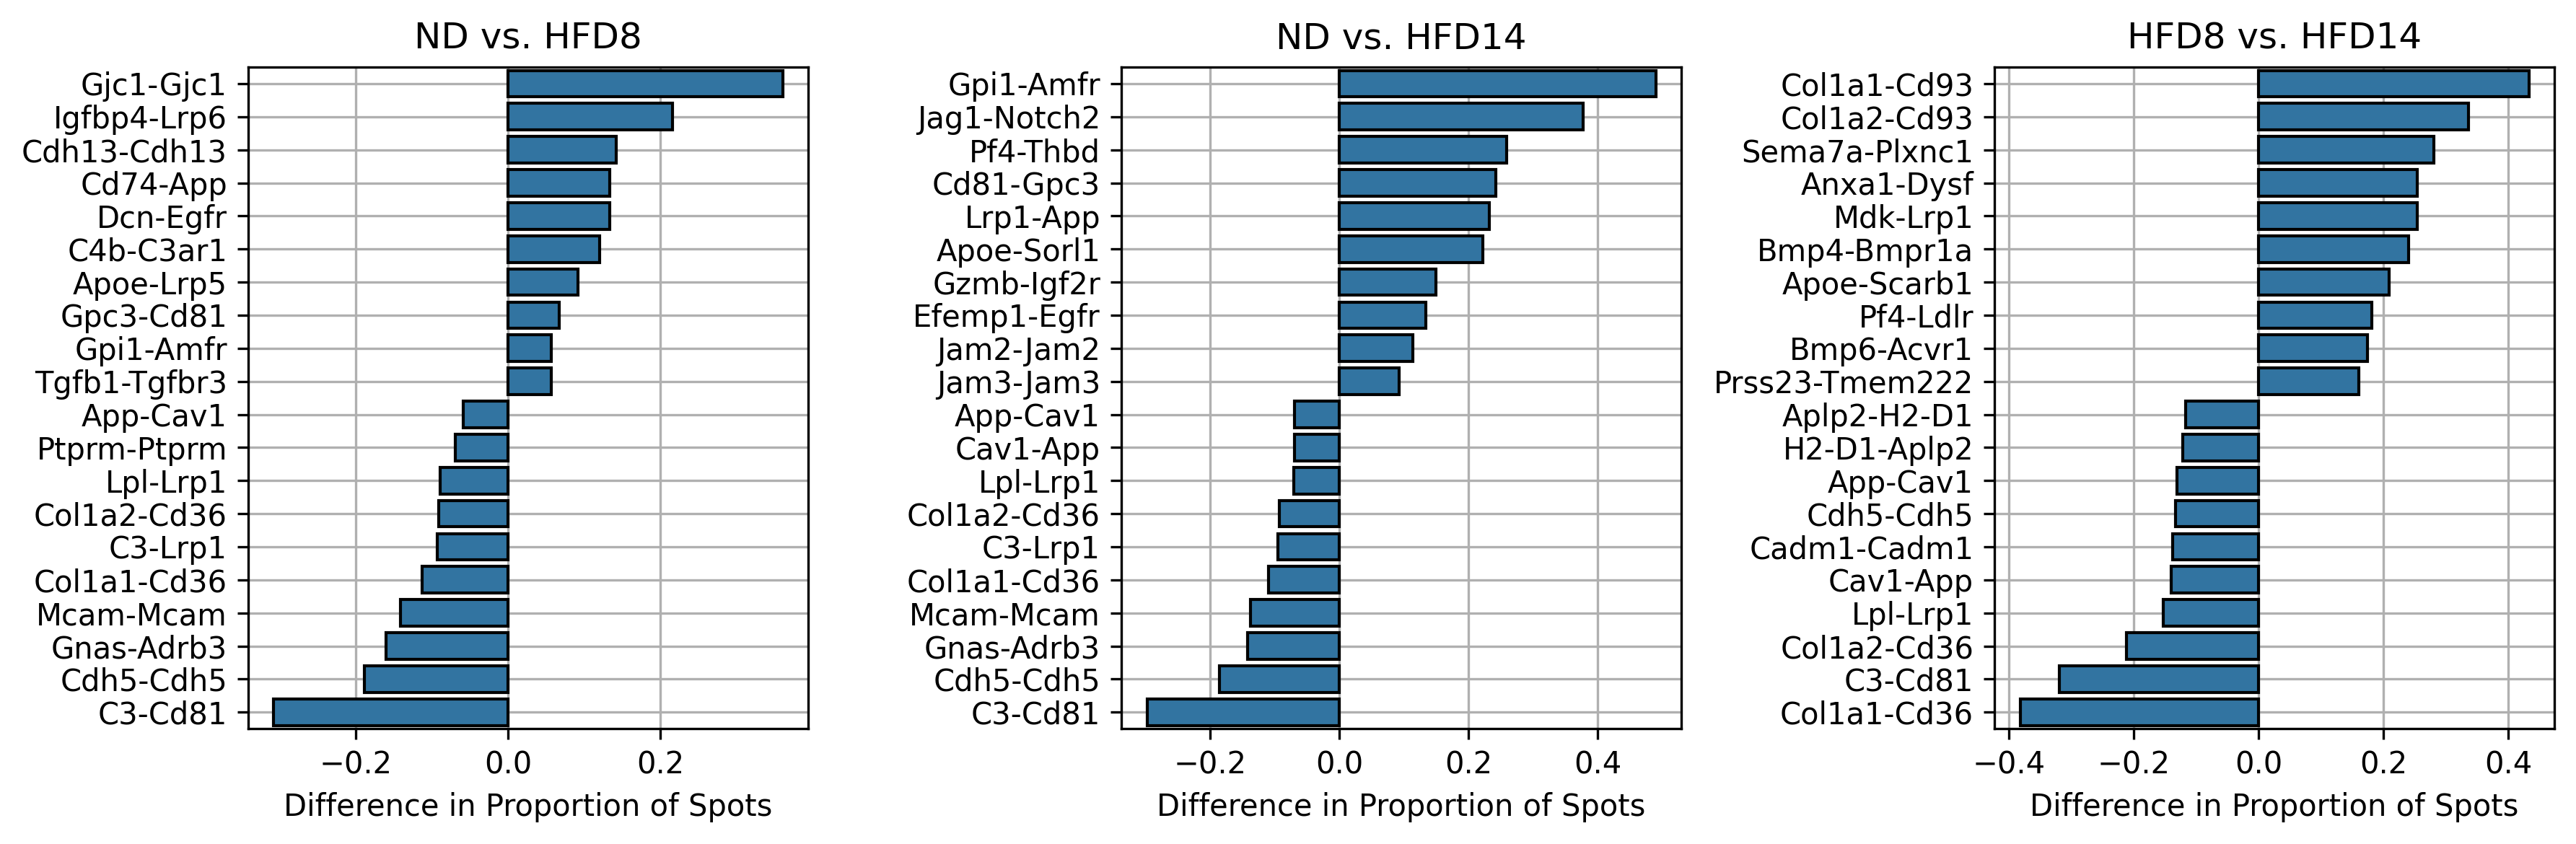

In [35]:
"""GSR for genes expressed in ER spots but not in ND """

n = 10
queryN = 50
show = 10
# db = 'WikiPathways_2019_Mouse'
# db = 'KEGG_2019_Mouse'
db = 'ontology'

comps = [
    ('ND', 'HFD8'),
    ('ND', 'HFD14'),
    ('HFD8', 'HFD14'),
]

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 12, 4
plt.rcParams['figure.facecolor'] = "w"

fig, axs = plt.subplots(1, 3)
axs = axs.ravel()

for i, (k1, k2) in enumerate(comps):
    
    k1df = lrExpDf[k1].sort_values(by='LR')
    k2df = lrExpDf[k2].sort_values(by='LR')
    
    diffs = k2df['Proportion'] - k1df['Proportion']
    
    ddf = pd.DataFrame({'LR' : k1df['LR'], 
                        'Difference' : diffs})

    ddf = ddf.sort_values(by='Difference', ascending=False)
    ddf = ddf[ddf['LR'].notna()]

    tb = pd.concat([ddf.head(n), ddf.tail(n)])
    
    print(f"==== {k1} vs. {k2} ====")
    print(tb)
    print()
    
    topGenes = ddf['LR'].head(queryN).to_list()
    bottomGenes = ddf['LR'].tail(queryN).to_list()
    
    topGenes = flatten([x.split("-") for x in topGenes])
    bottomGenes = flatten([x.split("-") for x in bottomGenes])
    

    
   
    print("Upregulated")
    pd.set_option('display.max_colwidth', 200)
    ef = gget.enrichr(topGenes, database=db)
    ef = ef[ef['p_val'] <= 0.05].reset_index(drop=True)
    printGSR(ef, show)
    
    print("Downregulated")
    pd.set_option('display.max_colwidth', 200)
    ef = gget.enrichr(bottomGenes, database=db)
    ef = ef[ef['p_val'] <= 0.05].reset_index(drop=True)
    printGSR(ef, show)
    

    sns.barplot(data=tb,
                x='Difference', 
                y='LR', 
                color='C0',
                edgecolor='k',
                zorder=2,
                ax=axs[i])
    
        
    axs[i].set_ylabel("")
    axs[i].set_xlabel("Difference in Proportion of Spots")
    axs[i].set_title(f"{k1} vs. {k2}")
    axs[i].grid(True, zorder=1)

plt.tight_layout()

# ER Markers in scRNA seq

In [ ]:
cardDir =  "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDInputs/"
keys = ['ND', 'HFD8', 'HFD14']

rna = {}
labels = {}

for key in keys:
    labelPath = f"{cardDir}{key}_macrophage_clusters.csv"
    lf = pd.read_csv(labelPath)
    labels[key] = lf
    
    rnaPath = f"{cardDir}{key}_macrophage_rna.csv"
    rf = pd.read_csv(rnaPath)
    rf = rf.T
    new_header = rf.iloc[0] 
    rf = rf[1:] 
    rf.columns = new_header 
    rf.index.names = ['cellId']
    
    rna[key] = rf

print('done')

# DE Analysis Cells with large numbers of ER markers expressed

In [ ]:
t = 100

deg = []

for key in keys:
    rf = rna[key]
    lf = labels[key]
    
    genes = list(rf.columns)
    
    rowSums = rf[ire].astype(bool).sum(axis=1) 
    mask = rowSums > t
    cellIds = rf[mask].index
    
    erCells = lf[lf['cellId'].isin(cellIds)]
    nCell = len(erCells)
    print(f"==== {key} {nCell=}====")
    print(erCells['cellType'].value_counts(normalize=True))
    print()
    
    inGroup = rf[mask]
    outGroup = rf[~mask]

    for i, g in enumerate(genes):
        scores, pvals = stats.ttest_ind_from_stats(
            mean1=inGroup[g].mean(),
            std1=inGroup[g].std(),
            nobs1=inGroup.shape[0],
            mean2=outGroup[g].mean(),
            std2=outGroup[g].std(),
            nobs2=outGroup.shape[0],
            equal_var=False,  # Welch's
        )
        
        lfc =  np.log(inGroup[g].mean()) - np.log(outGroup[g].mean())
        p = inGroup[g].astype(bool).sum() / mask.sum()
        
        isERMarker = False
        if g in ire:
            isERMarker = True
               
        row = {
            'key' : key,
            'gene' : g,
            'pval' : pvals,
            'logfoldchange' : lfc,
            'meanGroup' : inGroup[g].mean(),
            'meanOther' : outGroup[g].mean(),
            'isERMarker' : isERMarker,
            'percExp' : p,
        }
        
        deg.append(row)
        
    
deg = pd.DataFrame(deg)
print(f"{deg.shape=}")
deg.head()

In [ ]:
n = 5
show = 30
alpha = 0.05
nGene = 100

# db = 'WikiPathways_2019_Mouse'
# db = 'KEGG_2019_Mouse'
db = 'ontology'

for i, key in enumerate(keys):
    
    cdf = deg[deg['key'] == key]
    cdf = cdf[~cdf.isin([np.nan, np.inf, -np.inf]).any(1)]
    cdf = cdf[cdf['pval'] <= alpha]
    print(f"{key} {cdf.shape=}")
    
    cdf['score'] = cdf['logfoldchange'] * cdf['percExp']
    cdf = cdf.sort_values(by='score', ascending=False) 
    print(f"==== {key} ====")
    print(cdf[['gene', 'logfoldchange', 'meanGroup', 'meanOther', 'percExp', 'isERMarker']].head(show), '\n')
    
    query  = deg['gene'].head(nGene).to_list()
    
    pd.set_option('display.max_colwidth', 200)
    ef = gget.enrichr(query, database=db)
    ef = ef[ef['p_val'] <= alpha].reset_index(drop=True)
    printGSR(ef, show)
    print()
    
    
    
    # break
    

# Macrophage Subtype DE Analysis 

In [ ]:
deg = []

for key in keys:
    rf = rna[key]
    lf = labels[key]
    
    lf['isMac'] = lf['cellType'].apply(lambda x: 1 if 'Mac' in x else 0)
    
    lf = lf[lf['isMac'] == 1]

    # print(lf.columns)
    
    for ctype in sorted(cTypes):
        if 'Mac' in ctype:
            mask = lf['cellType'] == ctype
            cellIds = lf[mask]['cellId']

            inGroup = rf[rf.index.isin(cellIds)][ire]
            outGroup = rf[~rf.index.isin(cellIds) & rf.index.isin(lf['cellId'])][ire]
            
            for i, g in enumerate(ire):
                scores, pvals = stats.ttest_ind_from_stats(
                    mean1=inGroup[g].mean(),
                    std1=inGroup[g].std(),
                    nobs1=inGroup.shape[0],
                    mean2=outGroup[g].mean(),
                    std2=outGroup[g].std(),
                    nobs2=outGroup.shape[0],
                    equal_var=False,  # Welch's
                )

                lfc = np.log(inGroup[g].mean()) - np.log(outGroup[g].mean())
                p = inGroup[g].astype(bool).sum() / mask.sum()
                
                row = {
                    'key' : key,
                    'subtype' : ctype,
                    'gene' : g,
                    'pval' : pvals,
                    'logfoldchange' : lfc,
                    'meanGroup' : inGroup[g].mean(),
                    'meanOther' : outGroup[g].mean(),
                    'percExp' : p,
                }
        
                deg.append(row)
        
        
    
deg = pd.DataFrame(deg)
print(f"{deg.shape=}")
print(deg['subtype'].value_counts(normalize=True))
deg.head()

In [ ]:
# break

In [ ]:
# outpath = "~/temp/macERDiffExp.csv"

# deg.to_csv(outpath, index=False)
# deg.head()

In [ ]:
alpha = 0.05
show = 20

keys = ['ND', 'HFD8, ''HFD14']

for key in keys:
    cdf = deg[deg['key'] == key].reset_index(drop=True)

    for m in sorted(deg['subtype'].unique()):
        q = cdf[cdf['subtype'] == m].reset_index(drop=True)
        
        q['absLFC'] = np.abs(q['logfoldchange'])
        q['meanDiff'] = q['meanGroup'] - q['meanOther']
        q = q[~q.isin([np.nan, np.inf, -np.inf]).any(1)]
        q = q[q['pval'] <= alpha]
        q = q.sort_values(by='absLFC', ascending=False) 
        print(f"==== {key} {m} ====")
        print(q[['gene', 
                 'logfoldchange', 
                 'meanGroup',
                 'meanOther',
                 'meanDiff',
                 'percExp']].head(show), '\n')
    # break

In [ ]:
break

In [ ]:
for key in keys:
    rf = rna[key]
    lf = labels[key]
    
    genes = list(rf.columns)
    
    rowSums = rf[ire].astype(bool).sum(axis=1) 
    meanExp = rf[ire].mean(axis=1) 
    
    mask = rowSums > 0
    exp = rf[mask]

    lf = labels[key]
    genes = list(rf.columns)
    cellIds = rf[mask].index
    
    print(rowSums.shape, lf.shape)
    
    lf['nERN1'] = list(rowSums)
    lf['meanExp'] = list(meanExp)
    
    
    g = lf.groupby('cellType')['meanExp'].mean().reset_index()
    
    print(f"==== {key} ====")
    print(g)
    print()
    
#     erCells = lf[lf['cellId'].isin(cellIds)]
    
    
    
#     print(erCells.head())
    
    
    
    # break

In [ ]:
'MCM3' in ire